Valid samples: 500
Saved X_val.npy and y_val.npy


C:\Users\CLEMENTENA J\AppData\Local\Temp\ipykernel_16324\1950583919.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, labels = x.to(device), torch.tensor(labels).to(device)
C:\Users\CLEMENTENA J\AppData\Local\Temp\ipykernel_16324\1950583919.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, labels = x.to(device), torch.tensor(labels).to(device)


Epoch 1: Train Acc=0.44, Val Acc=0.57
Epoch 2: Train Acc=0.54, Val Acc=0.65
Epoch 3: Train Acc=0.59, Val Acc=0.67
Epoch 4: Train Acc=0.61, Val Acc=0.67
Epoch 5: Train Acc=0.57, Val Acc=0.70
Epoch 6: Train Acc=0.63, Val Acc=0.82
Epoch 7: Train Acc=0.57, Val Acc=0.82
Epoch 8: Train Acc=0.58, Val Acc=0.76
Epoch 9: Train Acc=0.55, Val Acc=0.80
Epoch 10: Train Acc=0.60, Val Acc=0.76
Epoch 11: Train Acc=0.61, Val Acc=0.84
Epoch 12: Train Acc=0.64, Val Acc=0.88
Epoch 13: Train Acc=0.56, Val Acc=0.90
Epoch 14: Train Acc=0.69, Val Acc=0.90
Epoch 15: Train Acc=0.57, Val Acc=0.77
Epoch 16: Train Acc=0.59, Val Acc=0.89
Epoch 17: Train Acc=0.62, Val Acc=0.92
Epoch 18: Train Acc=0.68, Val Acc=0.80
Epoch 19: Train Acc=0.61, Val Acc=0.94
Epoch 20: Train Acc=0.60, Val Acc=0.89
Epoch 21: Train Acc=0.65, Val Acc=0.97
Epoch 22: Train Acc=0.69, Val Acc=0.91
Epoch 23: Train Acc=0.64, Val Acc=0.93
Epoch 24: Train Acc=0.60, Val Acc=0.97
Epoch 25: Train Acc=0.67, Val Acc=0.97
Epoch 26: Train Acc=0.62, Val Acc=

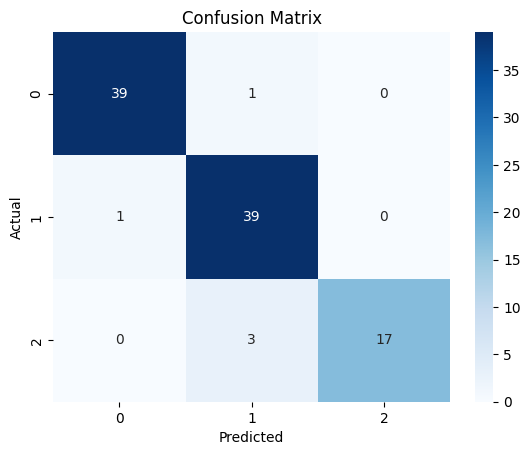

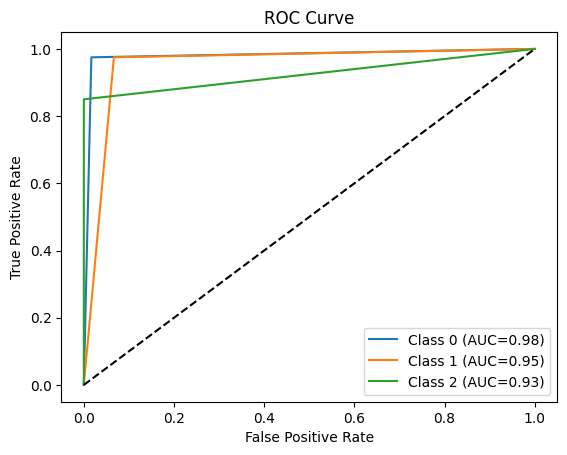

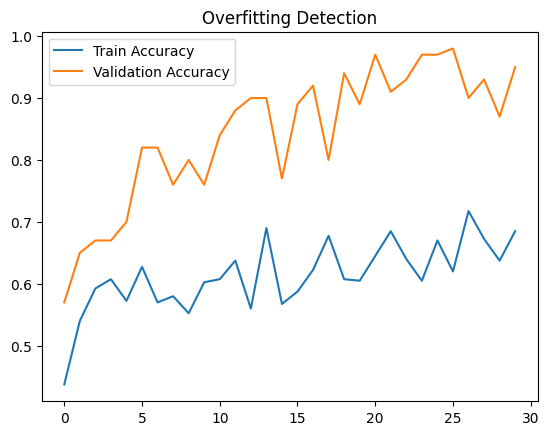

In [ ]:
# ====================== Existing Imports ======================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import resnet18
import seaborn as sns
import random

# ====================== Load and preprocess data ======================
def load_dataset(file_path, label):
    df = pd.read_excel(file_path)
    samples, labels = [], []
    for row in df['Content']:
        try:
            values = [float(i) for i in row.replace('\n', '-').split('-') if i.strip() != '']
            samples.append(values)
            labels.append(label)
        except:
            continue
    return samples, labels

X1, y1 = load_dataset("normal_data.xlsx", 0)
X2, y2 = load_dataset("epilepsy_without_seizure_data.xlsx", 1)
X3, y3 = load_dataset("epilepsy_with_seizure_data.xlsx", 2)

X = X1 + X2 + X3
y = y1 + y2 + y3

# ====================== EEG Dataset ======================
class EEGDataset(Dataset):
    def __init__(self, signals, labels):
        self.data = []
        self.labels = []

        for signal, label in zip(signals, labels):
            waveform = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)  # shape [1, signal_length]
            self.data.append(waveform)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = EEGDataset(X, y)
print("Valid samples:", len(dataset))

# ====================== Stratified Train-Val Split ======================
def stratified_split(dataset, labels, split_ratio=0.8):
    labels = np.array(labels)
    skf = StratifiedKFold(n_splits=int(1 / (1 - split_ratio)))
    train_idx, val_idx = next(skf.split(np.zeros(len(labels)), labels))
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

train_dataset, val_dataset = stratified_split(dataset, dataset.labels)

# === Save X_val and y_val as .npy files ===
val_signals, val_labels = [], []
for signal, label in val_dataset:
    val_signals.append(signal.squeeze(0).numpy())  # Remove channel dim
    val_labels.append(label)

np.save("X_val10.npy", np.array(val_signals))
np.save("y_val10.npy", np.array(val_labels))
print("Saved X_val.npy and y_val.npy")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# ====================== Mixup Augmentation ======================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ====================== Label Smoothing ======================
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, x, target):
        pred = x.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# ====================== Model ======================
class EEGModel(nn.Module):
    def __init__(self, num_classes=3):
        super(EEGModel, self).__init__()

        # 1D Convolution layer to capture temporal patterns
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3)
        self.pool = nn.MaxPool1d(2)

        # GRU layer for sequence modeling
        self.gru = nn.GRU(input_size=64, hidden_size=128, num_layers=2, batch_first=True, dropout=0.4)

        # Fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        _, h_n = self.gru(x)
        out = self.fc(h_n[-1])
        return out

# ====================== Train Model ======================
def train_model():
    model = EEGModel()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = LabelSmoothingLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_acc = 0
    patience = 5
    wait = 0

    train_accs, val_accs = [], []

    for epoch in range(30):
        model.train()
        correct, total = 0, 0
        for x, labels in train_loader:
            x, labels = x.to(device), torch.tensor(labels).to(device)
            x, y_a, y_b, lam = mixup_data(x, labels)
            optimizer.zero_grad()
            out = model(x)
            loss = lam * criterion(out, y_a) + (1 - lam) * criterion(out, y_b)
            loss.backward()
            optimizer.step()
            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, labels in val_loader:
                x, labels = x.to(device), torch.tensor(labels).to(device)
                out = model(x)
                preds = out.argmax(1)
                all_preds.extend(preds.cpu())
                all_labels.extend(labels.cpu())
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_eeg_model10.pth")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()

    # Load best model
    model.load_state_dict(torch.load("best_eeg_model10.pth"))

    # Final Evaluation
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    y_true = label_binarize(all_labels, classes=[0, 1, 2])
    y_score = label_binarize(all_preds, classes=[0, 1, 2])
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC={roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Overfitting Check
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.legend()
    plt.title("Overfitting Detection")
    plt.show()

# ====================== Run Training ======================
train_model()

In [ ]:
import numpy as np
import torch
import torch.nn as nn

# ====================== Model Definition ======================
class EEGModel(nn.Module):
    def __init__(self, num_classes=3):
        super(EEGModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3)
        self.pool = nn.MaxPool1d(2)
        self.gru = nn.GRU(input_size=64, hidden_size=128, num_layers=2, batch_first=True, dropout=0.4)
        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        _, h_n = self.gru(x)
        out = self.fc(h_n[-1])
        return out

# ====================== Load Model ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGModel()
model.load_state_dict(torch.load("best_eeg_model10.pth", map_location=device))
model.to(device)
model.eval()

# ====================== Load X_val ======================
X_val = np.load("X_val10.npy")  # shape: [N, signal_length]
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)  # shape: [N, 1, signal_length]

# ====================== Predict and Print ======================
y_val_pred = []
with torch.no_grad():
    for x in X_val_tensor:
        x = x.unsqueeze(0).to(device)
        output = model(x)
        pred = output.argmax(1).item()
        y_val_pred.append(pred)

# Convert to numpy array
y_val_pred = np.array(y_val_pred)

# ====================== Save & Print Predictions ======================
np.save("y_val_pred10.npy", y_val_pred)
print("Predicted labels (y_val_pred):")
print(y_val_pred)


Predicted labels (y_val_pred):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2]


In [ ]:
import numpy as np

# Load the true labels from file
y_val_true = np.load("y_val10.npy")

# Print the labels
print("True labels (y_val):")
print(y_val_true)


True labels (y_val):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
